In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import  (BaggingClassifier, 
                               RandomForestClassifier, 
                               StackingClassifier, 
                               GradientBoostingClassifier)
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

1. Получить данные.   
2. Подготовить датасет к обучению моделей.  
    a. Категориальные переменные перевести в цифровые значения. Можно использовать `pd.get_dummies`, `preprocessing.LabelEncoder`.
    b. \*Построить 1-2 графика на выбор.   
3. Разделить выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.  
4. Обучить дерево решений на обучающем множестве. Использовать модели:   
    a. `tree.DecisionTreeClassifier`   
    b. `ensemble.RandomForestClassifier`   
5. Для тестового множества сделать предсказание целевой переменной.
6. Вывести важность признаков. 
7. Обучить бэггинг над моделью из п. 4a. Используйте `ensemble.BaggingClassifier`.   
8. Обучить стекинг трех моделей: из п. 4a, п. 4b и `svm.LinearSVC`. Используйте `ensemble.StackingClassifier`.
9. Сформулируйте выводы.  

#### 1. Загружаем данные

In [2]:
heart_raw = pd.read_csv('./data/Heart.csv')

In [3]:
heart_raw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [4]:
heart = heart_raw.copy()

#### 2. Предобработка и EDA

In [5]:
pd.concat([heart.isnull().sum().rename('cnt'), round((heart.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
Age,0,0.000
Sex,0,0.000
ChestPainType,0,0.000
RestingBP,0,0.000
Cholesterol,0,0.000
FastingBS,0,0.000
RestingECG,0,0.000
MaxHR,0,0.000
ExerciseAngina,0,0.000
Oldpeak,0,0.000


In [6]:
categorials = heart.select_dtypes('object').columns

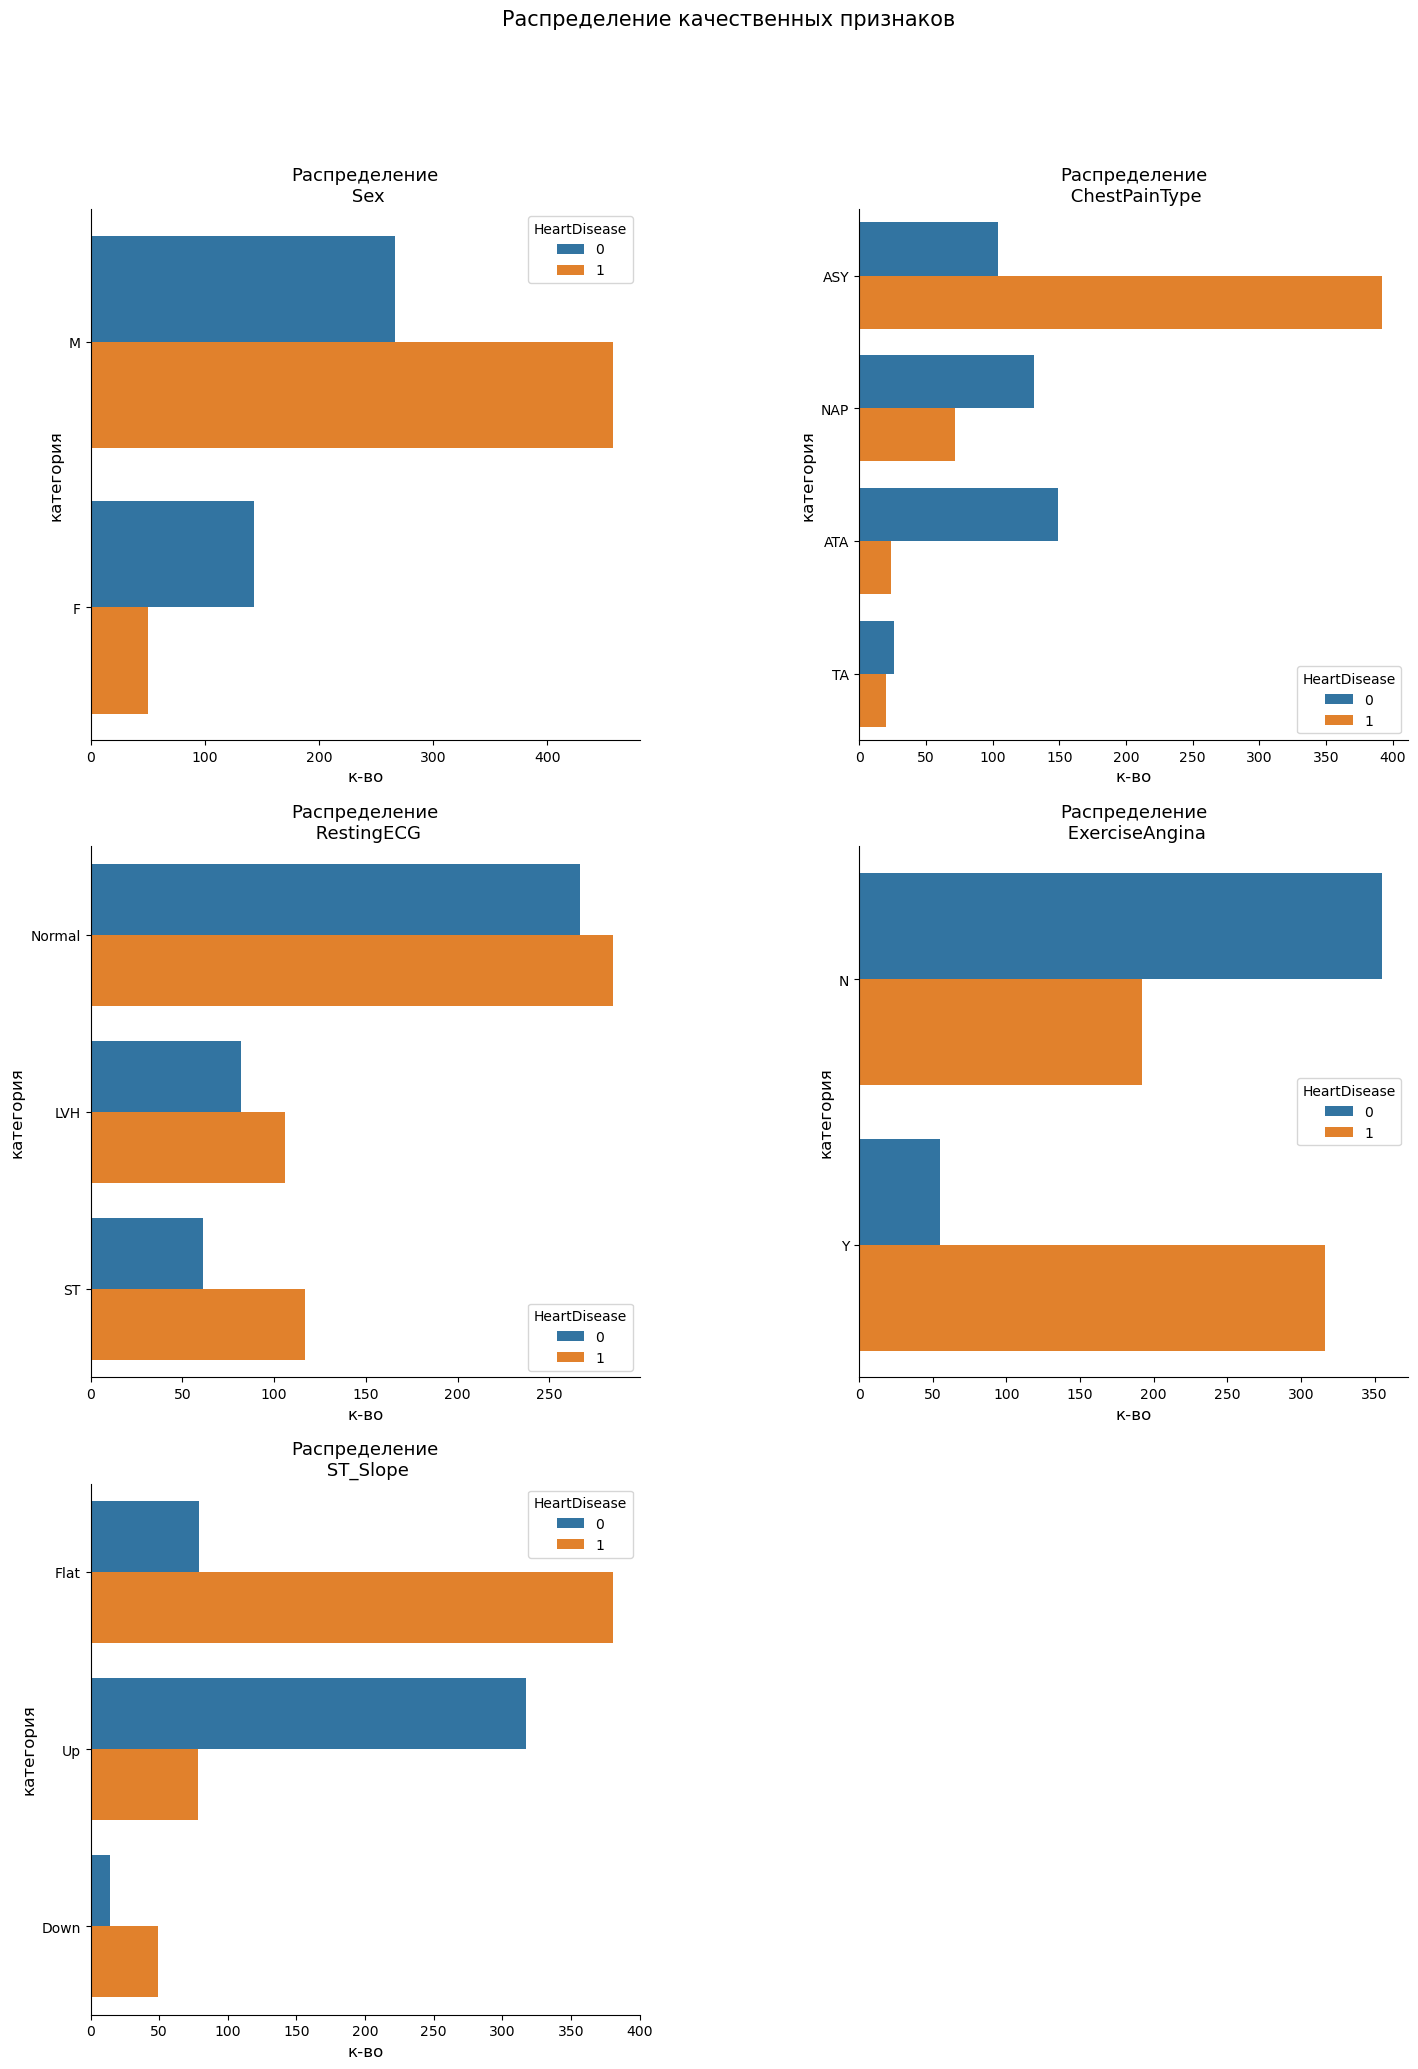

In [7]:
fig = plt.figure(figsize=(17,40))
cols = categorials
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.countplot(data=heart, y=col, order = heart[col].value_counts().index, hue='HeartDisease', linewidth=1)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('к-во', size=12)
    sns.despine()
    plt.ylabel('категория', size=12)
plt.suptitle('Распределение качественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

In [8]:
numeric = heart.select_dtypes(['int', 'float']).columns

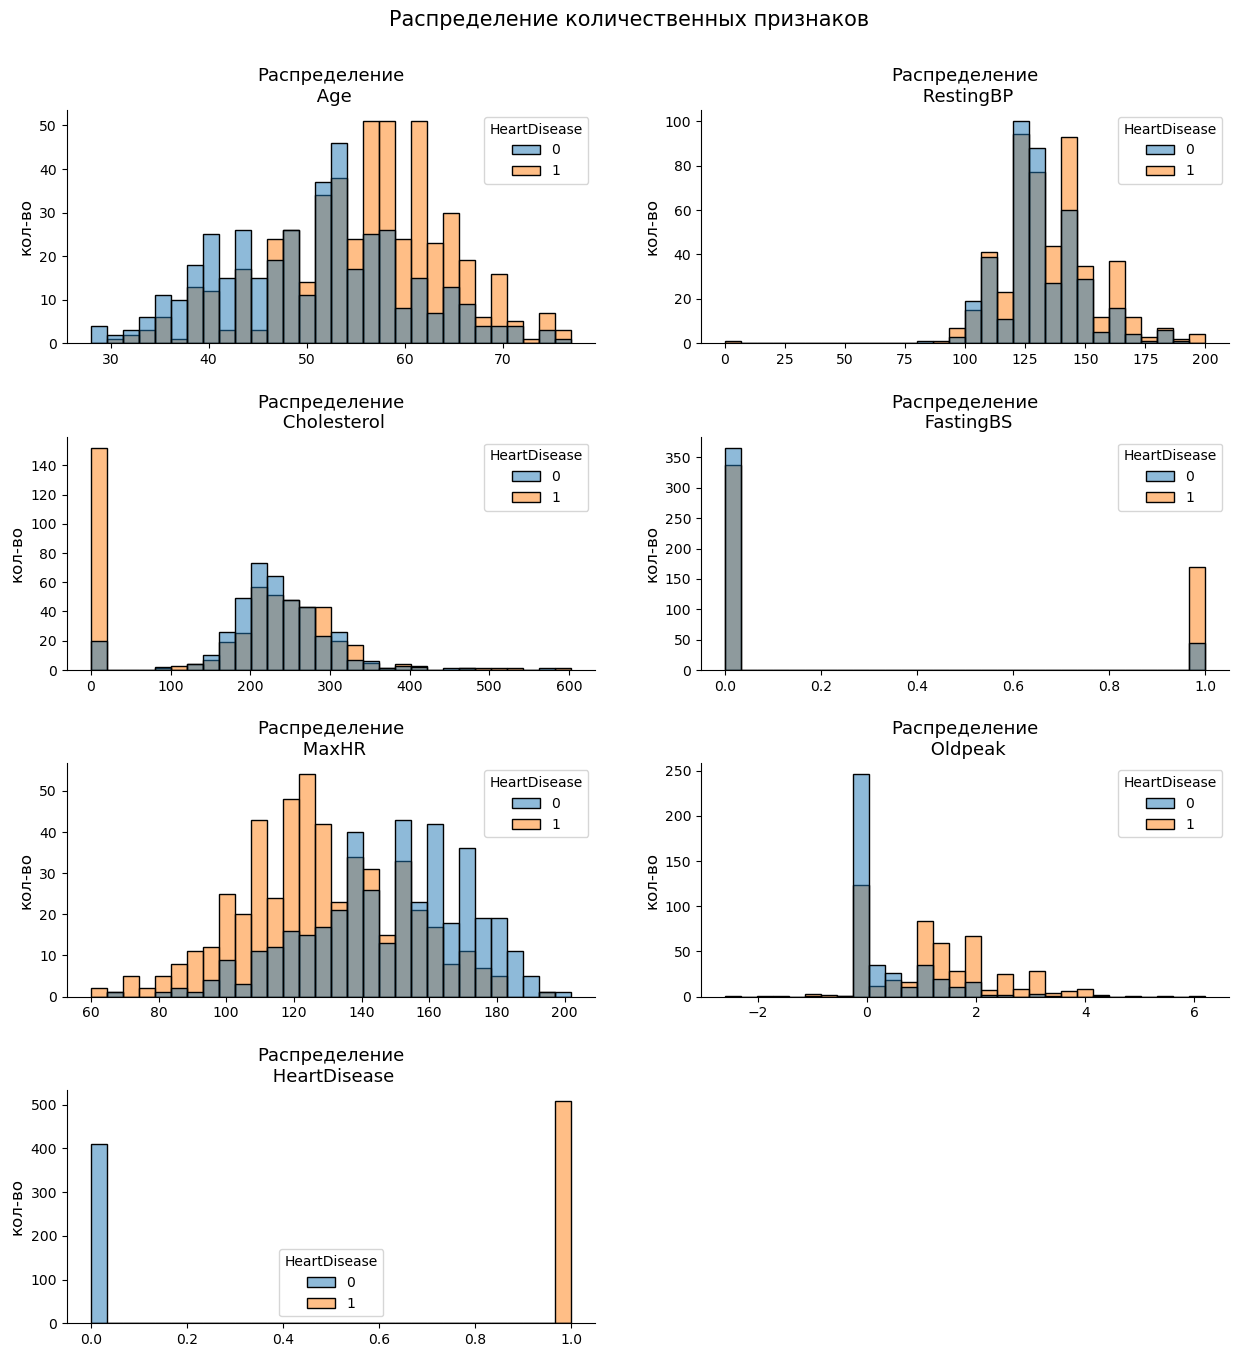

In [9]:
fig = plt.figure(figsize=(15,20))
cols = numeric
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=heart, x=col, hue='HeartDisease', kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Распределение количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [10]:
heart['Sex'] = heart['Sex'].map({'M': 0, 'F': 1})
heart['ExerciseAngina'] = heart['ExerciseAngina'].map({'N': 0, 'Y': 1})

In [11]:
heart = pd.get_dummies(data=heart, columns=heart.select_dtypes('object').columns).copy()

In [12]:
heart.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,0,0.000,0,0,1,0,0,0,1,0,0,0,1
1,49,1,160,180,0,156,0,1.000,1,0,0,1,0,0,1,0,0,1,0
2,37,0,130,283,0,98,0,0.000,0,0,1,0,0,0,0,1,0,0,1
3,48,1,138,214,0,108,1,1.500,1,1,0,0,0,0,1,0,0,1,0
4,54,0,150,195,0,122,0,0.000,0,0,0,1,0,0,1,0,0,0,1


#### 3. Разделение выборки

In [13]:
X,y = heart.drop(columns='HeartDisease', axis=1),heart['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((734, 18), (184, 18))

#### 4. Обучение `DecisionTreeClassifier` и `RandomForestClassifier`

In [14]:
def get_score(df, target, random_seed=42, model=None):
    if model is None:
        model = DecisionTreeClassifier(random_state=random_seed)
    
    X = df.drop([target], axis = 1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rep_train = classification_report(y_pred_train, y_train, digits=3)
    print(model)
    print('='* 70)
    print('TRAIN ', rep_train)
    print('-'* 70)
    rep_test = classification_report(y_pred_test, y_test, digits=3)
    print('TEST ', rep_test)
    print('='* 70)

В задании рекомендуется использовать `metrics.classification_report`, но мне кажется неудобно будет сравнивать модели прокручивая несколько экранов. Буду дополнять метриками небольшой датафрейм

In [15]:
def get_score_df(df, target, random_seed=42, model=None, title='dtc_default'):
    start_time = time.time()
    if model is None:
        model = DecisionTreeClassifier(random_state=random_seed)
    
    X = df.drop([target], axis = 1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 


    model.fit(X_train.values, y_train)
    y_pred_train = model.predict(X_train.values)
    y_pred_test = model.predict(X_test.values)
    duration = str(round((time.time() - start_time), 4)) + ' sec'
    

    accuracy_train = model.score(X_train.values, y_train)
    accuracy_test = model.score(X_test.values, y_test)
    f1_train = f1_score(y_pred_train, y_train)
    f1_test = f1_score(y_pred_test, y_test)

    metrix = {}
    metrix['duration'] = duration
    metrix['accuracy_train'] = accuracy_train
    metrix['accuracy_test'] = accuracy_test
    metrix['f1_train'] = f1_train
    metrix['f1_test'] = f1_test
    res = pd.DataFrame.from_dict(metrix, orient='index', columns=[title])
    
    return res

#### 5. Метрики

In [16]:
get_score(heart, 'HeartDisease', model=DecisionTreeClassifier(
    min_samples_leaf=6,
    random_state=42))

DecisionTreeClassifier(min_samples_leaf=6, random_state=42)
TRAIN                precision    recall  f1-score   support

           0      0.904     0.899     0.901       335
           1      0.915     0.920     0.917       399

    accuracy                          0.910       734
   macro avg      0.910     0.909     0.909       734
weighted avg      0.910     0.910     0.910       734

----------------------------------------------------------------------
TEST                precision    recall  f1-score   support

           0      0.870     0.770     0.817        87
           1      0.813     0.897     0.853        97

    accuracy                          0.837       184
   macro avg      0.842     0.834     0.835       184
weighted avg      0.840     0.837     0.836       184



In [17]:
res = pd.DataFrame()

In [18]:
%%time
res_0 = get_score_df(heart, 'HeartDisease', model=DecisionTreeClassifier(
    min_samples_leaf=6,
    random_state=42), title='dtc_min_leaf=6')
res = pd.concat([res, res_0], axis=1)
res.T

CPU times: user 7.2 ms, sys: 1.18 ms, total: 8.37 ms
Wall time: 7.4 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853


Метрики считаются правильно. Далее используем метод датафрейма

In [19]:
%%time
res_1 = get_score_df(heart, 'HeartDisease', model=RandomForestClassifier(
    n_estimators=50,
    max_features=6,
    max_samples=.6,
    random_state=42), title='rfc_max_feat=6_max_sampl=0.6')
res = pd.concat([res, res_1], axis=1)
res.T

CPU times: user 68.4 ms, sys: 1.97 ms, total: 70.4 ms
Wall time: 69.2 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906


In [20]:
%%time
res_1 = get_score_df(heart, 'HeartDisease', model=RandomForestClassifier(
    random_state=42), title='rfc_default')
res = pd.concat([res, res_1], axis=1)
res.T

CPU times: user 137 ms, sys: 3.14 ms, total: 140 ms
Wall time: 138 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906
rfc_default,0.1189 sec,1.000,0.897,1.000,0.910


#### 6. Важность признаков

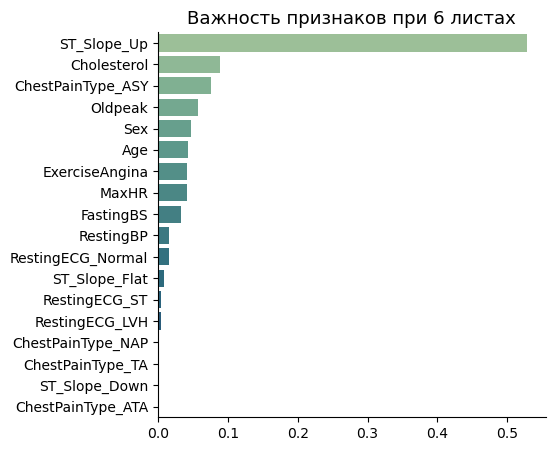

In [21]:
fig = plt.figure(figsize=(5,5))
regr = DecisionTreeClassifier(
    min_samples_leaf=6, 
    random_state=42)
model = regr.fit(X_train.values, y_train)
y_pred = model.predict(X_train.values)
feature_imp = pd.Series(regr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, palette='crest', y=feature_imp.index)
plt.title(f'Важность признаков при 6 листах', size=13)
plt.xlabel('', size=8)
sns.despine()
plt.ylabel('', size=8)
plt.show()

#### 7. Бэггинг

In [22]:
%%time
res_2 = get_score_df(heart, 'HeartDisease', model=BaggingClassifier(
    base_estimator = DecisionTreeClassifier(
        min_samples_leaf=6),
    n_estimators=50,
    max_features=6,
    max_samples=.6,
    random_state=42), title='baggcl_max_feat=6_max_sampl=0.6')
res = pd.concat([res, res_2], axis=1)
res.T

CPU times: user 69.3 ms, sys: 1.79 ms, total: 71.1 ms
Wall time: 70.1 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906
rfc_default,0.1189 sec,1.000,0.897,1.000,0.910
baggcl_max_feat=6_max_sampl=0.6,0.0598 sec,0.896,0.886,0.908,0.902


#### 8. Стекинг

In [23]:
%%time
res_3 = get_score_df(
    heart, 
    'HeartDisease', 
    model=StackingClassifier(
        [
            ('DecisionTreeClassifier', DecisionTreeClassifier(
                min_samples_leaf=6,
                random_state=42)),
            ('RandomForestClassifier', RandomForestClassifier(
                max_features=6,
                max_samples=.6,
                random_state=42)),
            ('LinearSVC', LinearSVC(max_iter=10000))
        ], RidgeClassifierCV()
    ), title='stack_svc'
)
res = pd.concat([res, res_3], axis=1)
res.T

CPU times: user 2.22 s, sys: 7.95 ms, total: 2.23 s
Wall time: 2.23 s


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906
rfc_default,0.1189 sec,1.000,0.897,1.000,0.910
baggcl_max_feat=6_max_sampl=0.6,0.0598 sec,0.896,0.886,0.908,0.902
stack_svc,2.2123 sec,0.947,0.891,0.953,0.908


In [24]:
%%time
res_4 = get_score_df(
    heart, 
    'HeartDisease', 
    model=StackingClassifier(
        [
            ('DecisionTreeClassifier', DecisionTreeClassifier(
                min_samples_leaf=6,
                random_state=42)),
            ('RandomForestClassifier', RandomForestClassifier(
                max_features=6,
                max_samples=.6,
                random_state=42)),
            ('BaggingClassifier', BaggingClassifier(
                base_estimator = DecisionTreeClassifier(
                    min_samples_leaf=6),
                n_estimators=50,
                max_features=6,
                max_samples=.6,
                random_state=42))
        ], RidgeClassifierCV()
    ), title='stack_baggcl'
)
res = pd.concat([res, res_4], axis=1)
res.T

CPU times: user 905 ms, sys: 9.78 ms, total: 915 ms
Wall time: 915 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906
rfc_default,0.1189 sec,1.000,0.897,1.000,0.910
baggcl_max_feat=6_max_sampl=0.6,0.0598 sec,0.896,0.886,0.908,0.902
stack_svc,2.2123 sec,0.947,0.891,0.953,0.908
stack_baggcl,0.8874 sec,0.936,0.880,0.942,0.896


#### 9. Выводы:  
1. Из отмеченных моделей самая худшая модель по метрикам и переобучаемости __Дерево решений__, но она же и самая быстрая. Это объясняется относительной простотой алгоритма
2. У __Случайного леса__ с дефолтными настройками самые высокие метрики на тесте и хорошая скорость, но она сильно переобучается. Это обусловлено тем что лес собственно состоит их переобученных деревьев 
3. __Случайный лес__ с ограничениями показывает довольно высокие метрики на тесте и переучивается чуть меньше, но все же переучивается, из-за влияние некоторых переученных деревьев
4. __Стекинг с SVM__ и __Стекинг с бэггингом из деревьев__ мало чем отличаются по не лучшим метрикам, но __Стекинг с SVM__ в 2 раза медленней. Это из-за того что __SVM__ сам по себе медленный.
5. Самая лучшая модель по метрикам, переробучаемости и времени оказался __Бэггинг__ . *(Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе выбирается случайное подмножество признаков, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле)*. __Очень странно - алгоритм вроде менее оптимальный чем случайный лес, а метрики лучше__

#### \*Бонус

In [25]:
%%time
res_5 = get_score_df(heart, 'HeartDisease', model=GradientBoostingClassifier(
    max_features=10,
    n_estimators=25,
    min_samples_leaf=5,
    random_state=42), title='gbc_max_feat=10_min_leaf=5')
res = pd.concat([res, res_5], axis=1)
res.T

CPU times: user 26.3 ms, sys: 1.53 ms, total: 27.9 ms
Wall time: 27 ms


,duration,accuracy_train,accuracy_test,f1_train,f1_test
dtc_min_leaf=6,0.005 sec,0.910,0.837,0.917,0.853
rfc_max_feat=6_max_sampl=0.6,0.0588 sec,0.973,0.891,0.975,0.906
rfc_default,0.1189 sec,1.000,0.897,1.000,0.910
baggcl_max_feat=6_max_sampl=0.6,0.0598 sec,0.896,0.886,0.908,0.902
stack_svc,2.2123 sec,0.947,0.891,0.953,0.908
stack_baggcl,0.8874 sec,0.936,0.880,0.942,0.896
gbc_max_feat=10_min_leaf=5,0.0234 sec,0.891,0.891,0.903,0.905


Если поэкспериментировать с моделями и добавить __Градиентный бустинг__ суть которого в том что ошибки предыдущих деревьев становятся целевыми значениями последующих, мы получим наилучший результат по метрикам, обучаемости и времени.

Результат этой работы понадобится в дз про улучшение качества модели

In [26]:
result_final = res.to_dict('series')

In [27]:
with open('./data/result.pkl', 'wb') as f:
    pickle.dump(result_final, f)